# Aerodynamic Splatting

In [1]:
import numpy as np
from sympy import symbols, diff, Quaternion, exp, Matrix, lambdify, sin, cos, simplify
#from sympy.physics.mechanics import *
import random
from IPython.display import display
import matplotlib.pyplot as plt

## Create Symbolic Functions

### Properties of the splat

In [2]:
x, y, z, u, v, w, sx, sy, sz, qw, qx, qy, qz, θ = symbols("x, y, z, u, v, w, s_x, s_y, s_z, q_w, q_x, q_y, q_z, θ")
position = np.array([x, y, z])
velocity = np.array([u, v, w])
scale = np.array([sx, sy, sz])
orientation_2d = θ
orientation_3d = np.array([qw, qx, qy, qz])
splat_properties_2d = [x, y, u, v, sx, sy, θ]
splat_properties_2d_example = [0, 0] + [1, 0] + [1, 1] + [0] + [2, 0]
splat_properties_3d = [x, y, z, u, v, w, sx, sy, sz, qw, qx, qy, qz]
splat_properties_3d_example = [0, 0, 0] + [1, 0, 0] + [1, 1, 1] + [1, 0, 0, 0] + [2, 0, 0] 

### Position for evaluation of the splat equations

In [3]:
xp, yp, zp = symbols("x_p, y_p, z_p")
eval_coords_2d = [xp, yp]
eval_coords_3d = [xp, yp, zp]
eval_at_position = np.array(eval_coords_3d)

## Equation for quaternion
We provide two options for obtaining the quaternon.
In the case where a `numpy` array with four quaternion components are provided, we will obtain using the standard syntax `Quaternion(qw, qx, qy, qz)`.
In the case where a single component is provided, we will assume that this is a planar model with an angle evaluated about the $z$-axis, and obtain with the `Quaternion.from_axis_angle` class method.
We also will create the `idx_dimension` variable which shrinks subsequent matrices and vectors to use only the first two ($x$ and $y$) components.

In [4]:
def quat(q):
    if isinstance(q, np.ndarray) :
        return Quaternion(*q) 
    else: 
        return Quaternion.from_axis_angle([0, 0, 1], q)
idx_dimension = lambda orientation: 3 if isinstance(orientation, np.ndarray) else 2

In [5]:
quaternion_2d = quat(orientation_2d)
display(quaternion_2d)

cos(θ/2) + 0*i + 0*j + sin(θ/2)*k

In [6]:
quaternion_3d = quat(orientation_3d)
display(quaternion_3d)

q_w + q_x*i + q_y*j + q_z*k

## Equation for gaussian

The Gaussian equation that is created below uses the variance term _not-squared_, while in the plot I square this term.
There is reason for this; the variance that I will use below is going to be of the form

$\texttt{variance} = \sum_{i=1}^3 \left( \frac{x_i - \bar{x}_i}{s_i} \right)^2$

where $x_i$ is a position coordinate for where we are measuring, $\bar{x}_i$ is the position coordinate for the center of the Gaussian, and $s_i$ is a scale coefficient representing one standard deviation in the direction of that coordinate.
Traditionally, we would evaluate the Gaussian at some count of standard deviations, which would derive from the square-root of the above expression.
To avoid taking a square-root, just to subsequently square the term again, we create the Gaussian as a function of the variance directly.
However, the plot below shows an evaluation of the Gaussian with respect to standard deviations.

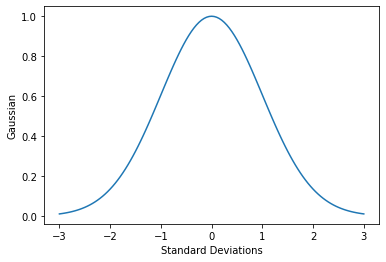

In [7]:
gaussian = lambda variance: exp(-0.5 * variance)
stdev = np.linspace(-3, 3, 121);
plt.plot(stdev, np.exp(-0.5 * stdev**2));
plt.xlabel("Standard Deviations");
plt.ylabel("Gaussian");

Here we create a function that obtains the rotation matrix from the quaternion, along with some simplification steps.
First, we substitute a value of 1 for the quaternion norm, as we will ensure that it is always a proper unit quaternion.
Second, we call the standard `simplify()` function.

In [8]:
def rotation_matrix_eqn(orientation):
    quaternion = quat(orientation)
    rotation_matrix = quaternion.to_rotation_matrix().subs(quaternion.norm(), 1)
    rotation_matrix.simplify()
    idx = idx_dimension(orientation)
    return rotation_matrix[:idx, :idx]

In [9]:
rotation_eqn_2d = rotation_matrix_eqn(orientation_2d)
rotation_fcn_2d = lambdify(θ, rotation_eqn_2d)
display(rotation_eqn_2d)
display(rotation_fcn_2d(0.5))

Matrix([
[cos(θ), -sin(θ)],
[sin(θ),  cos(θ)]])

array([[ 0.87758256, -0.47942554],
       [ 0.47942554,  0.87758256]])

In [10]:
rotation_eqn_3d = rotation_matrix_eqn(orientation_3d)
rotation_fcn_3d = lambdify(orientation_3d, rotation_eqn_3d)
display(rotation_eqn_3d)
display(rotation_fcn_3d(0.707, 0.707, 0, 0))

Matrix([
[-2*q_y**2 - 2*q_z**2 + 1,   -2*q_w*q_z + 2*q_x*q_y,    2*q_w*q_y + 2*q_x*q_z],
[   2*q_w*q_z + 2*q_x*q_y, -2*q_x**2 - 2*q_z**2 + 1,   -2*q_w*q_x + 2*q_y*q_z],
[  -2*q_w*q_y + 2*q_x*q_z,    2*q_w*q_x + 2*q_y*q_z, -2*q_x**2 - 2*q_y**2 + 1]])

array([[ 1.00000e+00,  0.00000e+00,  0.00000e+00],
       [ 0.00000e+00,  3.02000e-04, -9.99698e-01],
       [ 0.00000e+00,  9.99698e-01,  3.02000e-04]])

In [11]:
def variance_eqn(orientation):
    rotation_matrix = rotation_matrix_eqn(orientation)
    idx = idx_dimension(orientation)
    dx = rotation_matrix[:idx, :idx] @ (eval_at_position[:idx] - position[:idx])
    s = dx / scale[:idx]
    return np.sum(s**2)

In [12]:
variance_eqn_2d = variance_eqn(orientation_2d)
variance_fcn_2d = lambdify(splat_properties_2d + eval_coords_2d, variance_eqn_2d)
display(variance_eqn_2d)
display(variance_fcn_2d(*splat_properties_2d_example))

((-x + x_p)*sin(θ) + (-y + y_p)*cos(θ))**2/s_y**2 + ((-x + x_p)*cos(θ) - (-y + y_p)*sin(θ))**2/s_x**2

4.0

In [13]:
variance_eqn_3d = variance_eqn(orientation_3d)
variance_fcn_3d = lambdify(splat_properties_3d + eval_coords_3d, variance_eqn_3d)
display(variance_eqn_3d)
display(variance_fcn_3d(*splat_properties_3d_example))

((-x + x_p)*(-2*q_w*q_y + 2*q_x*q_z) + (-y + y_p)*(2*q_w*q_x + 2*q_y*q_z) + (-z + z_p)*(-2*q_x**2 - 2*q_y**2 + 1))**2/s_z**2 + ((-x + x_p)*(2*q_w*q_z + 2*q_x*q_y) + (-y + y_p)*(-2*q_x**2 - 2*q_z**2 + 1) + (-z + z_p)*(-2*q_w*q_x + 2*q_y*q_z))**2/s_y**2 + ((-x + x_p)*(-2*q_y**2 - 2*q_z**2 + 1) + (-y + y_p)*(-2*q_w*q_z + 2*q_x*q_y) + (-z + z_p)*(2*q_w*q_y + 2*q_x*q_z))**2/s_x**2

4.0

Velocity away from the center of the Gaussian takes the form

$\boldsymbol{x} = (x, y, z, u, v, w, s_x, s_y, s_z, q_w, q_x, q_y, q_z)$

$\boldsymbol{x}_p = (x_p, y_p, z_p)$

$\boldsymbol{v(\boldsymbol{x}, \boldsymbol{x}_p)} = \boldsymbol{v_0(\boldsymbol{x})} g(\boldsymbol{x}, \boldsymbol{x}_p)$

In [14]:
def velocity_eqn(orientation):
    idx = idx_dimension(orientation)
    variance = variance_eqn(orientation)
    return velocity[:idx] * gaussian(variance)

In [15]:
velocity_eqn_2d = velocity_eqn(orientation_2d)
velocity_fcn_2d = lambdify(splat_properties_2d + eval_coords_2d, list(velocity_eqn_2d))
display(Matrix(velocity_eqn_2d))
display(velocity_fcn_2d(*splat_properties_2d_example))

Matrix([
[u*exp(-0.5*((-x + x_p)*sin(θ) + (-y + y_p)*cos(θ))**2/s_y**2 - 0.5*((-x + x_p)*cos(θ) - (-y + y_p)*sin(θ))**2/s_x**2)],
[v*exp(-0.5*((-x + x_p)*sin(θ) + (-y + y_p)*cos(θ))**2/s_y**2 - 0.5*((-x + x_p)*cos(θ) - (-y + y_p)*sin(θ))**2/s_x**2)]])

[0.1353352832366127, 0.0]

In [16]:
velocity_eqn_3d = velocity_eqn(orientation_3d)
velocity_fcn_3d = lambdify(splat_properties_3d + eval_coords_3d, list(velocity_eqn_3d))
#display(Matrix(velocity_eqn_3d))
display(velocity_fcn_3d(*splat_properties_3d_example))

[0.1353352832366127, 0.0, 0.0]

In [17]:
diff_variance_eqn_2d = [diff(variance_eqn_2d, variable) for variable in splat_properties_2d]
diff_variance_fcn_2d = lambdify(splat_properties_2d + eval_coords_2d, list(diff_variance_eqn_2d))
#display(Matrix(diff_variance_eqn_2d))
display(diff_variance_fcn_2d(*splat_properties_2d_example))

[-4.0, 0.0, 0, 0, -8.0, -0.0, 0.0]

In [18]:
diff_variance_eqn_3d = [diff(variance_eqn_3d, variable) for variable in splat_properties_3d]
diff_variance_fcn_3d = lambdify(splat_properties_3d + eval_coords_3d, list(diff_variance_eqn_3d))
#display(Matrix(diff_variance_eqn_3d))
display(diff_variance_fcn_3d(*splat_properties_3d_example))

[-4.0, 0.0, 0.0, 0, 0, 0, -8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [19]:
diff_gaussian_eqn_2d = [diff(gaussian(variance_eqn_2d), variable) for variable in splat_properties_2d]
diff_gaussian_fcn_2d = lambdify(splat_properties_2d + eval_coords_2d, list(diff_gaussian_eqn_2d))
#display(Matrix(diff_gaussian_eqn_2d))
display(diff_gaussian_fcn_2d(*splat_properties_2d_example))

[0.2706705664732254, 0.0, 0, 0, 0.5413411329464508, 0.0, -0.0]

In [20]:
diff_gaussian_eqn_3d = [diff(gaussian(variance_eqn_3d), variable) for variable in splat_properties_3d]
diff_gaussian_fcn_3d = lambdify(splat_properties_3d + eval_coords_3d, list(diff_gaussian_eqn_3d))
#display(Matrix(diff_gaussian_eqn_3d))
display(diff_gaussian_fcn_3d(*splat_properties_3d_example))

[0.2706705664732254,
 0.0,
 0.0,
 0,
 0,
 0,
 0.5413411329464508,
 0.0,
 0.0,
 -0.0,
 -0.0,
 0.0,
 -0.0]

### Velocity derivative equations

Velocity is 1x2 or 1x3

Variance derivates are 1xN

$
\frac{\partial \boldsymbol{v(\boldsymbol{x}, \boldsymbol{x}_p)} }{\partial x_i}
= 
\frac{\partial \boldsymbol{v_0(\boldsymbol{x})}}{\partial x_i}
g(\boldsymbol{x}, \boldsymbol{x}_p)
+
\boldsymbol{v_0(\boldsymbol{x})}
\frac{\partial g(\boldsymbol{x}, \boldsymbol{x}_p)}{\partial x_i}
$

In [21]:
def velocity_derivatives(ndim):
    if ndim == 2:
        return Matrix(np.concatenate([np.zeros([2, 2]), np.diag([1, 1]), np.zeros([3, 2])]))
    elif ndim == 3:
        return Matrix(np.concatenate([np.zeros([3, 3]), np.diag([1, 1, 1]), np.zeros([7, 3])]))

In [22]:
diff_velocity_eqn_2d = velocity_derivatives(2)*gaussian(variance_eqn_2d) + Matrix(diff_gaussian_eqn_2d) * Matrix([u, v]).transpose()
diff_velocity_fcn_2d = lambdify(splat_properties_2d + eval_coords_2d, diff_velocity_eqn_2d)
#display(diff_velocity_eqn_2d)
display(diff_velocity_fcn_2d(*splat_properties_2d_example))

array([[ 0.27067057,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.13533528,  0.        ],
       [ 0.        ,  0.13533528],
       [ 0.54134113,  0.        ],
       [ 0.        ,  0.        ],
       [-0.        , -0.        ]])

In [23]:
diff_velocity_eqn_3d = velocity_derivatives(3)*gaussian(variance_eqn_3d) + Matrix(diff_gaussian_eqn_3d) * Matrix([u, v, w]).transpose()
diff_velocity_fcn_3d = lambdify(splat_properties_3d + eval_coords_3d, diff_velocity_eqn_3d)
#display(diff_velocity_eqn_3d)
display(diff_velocity_fcn_3d(*splat_properties_3d_example))

array([[ 0.27067057,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.13533528,  0.        ,  0.        ],
       [ 0.        ,  0.13533528,  0.        ],
       [ 0.        ,  0.        ,  0.13533528],
       [ 0.54134113,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [-0.        , -0.        , -0.        ],
       [-0.        , -0.        , -0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [-0.        , -0.        , -0.        ]])

## Create Splatting Class

In [24]:
class AeroSplat:
    position = np.zeros(3)
    velocity = np.zeros(3)
    scale = np.ones(3)
    orientation = np.array([1, 0, 0, 0])
    
    def __init__(self, **kwargs):
        for key, value in kwargs.items():
            setattr(self, key, np.array(value))
    
    def __repr__(self):
        return f"AeroSplat(position={self.position}, velocity={self.velocity}, scale={self.scale}, orientation={self.orientation})"
    
    @property
    def is2d(self):
        return len(self.position) == 2
    
    @property
    def properties(self):
        return np.concatenate([self.position, self.velocity, self.scale, self.orientation])
    
    @property
    def quaternion(self):
        return quat(*self.orientation) if self.is2d else quat(self.orientation)
    
    @property
    def rotation_matrix(self):
        return rotation_fcn_2d(*self.orientation) if self.is2d else rotation_fcn_3d(*self.orientation)
    
    @property
    def scale_matrix(self):
        return np.diag(self.scale)
    
    def properties_at(self, position):
        return list(self.properties) + list(position)
    
    def velocity_at(self, position):
        return velocity_fcn_2d(*self.properties_at(position)) if self.is2d else velocity_fcn_3d(*self.properties_at(position))
    
    def differential_velocity_at(self, position):
        return diff_velocity_fcn_2d(*self.properties_at(position)) if self.is2d else diff_velocity_fcn_3d(*self.properties_at(position))

        

In [25]:
a = AeroSplat(
    position=[0, 0], 
    velocity=[1, 0],
    scale=[1, 1],
    orientation=[0]
)
display(a)
display(a.quaternion)
display(a.rotation_matrix)
display(a.velocity_at(np.array([2, 0])))
display(a.differential_velocity_at(np.array([2, 0])))

AeroSplat(position=[0 0], velocity=[1 0], scale=[1 1], orientation=[0])

1 + 0*i + 0*j + 0*k

array([[ 1., -0.],
       [ 0.,  1.]])

[0.1353352832366127, 0.0]

array([[ 0.27067057,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.13533528,  0.        ],
       [ 0.        ,  0.13533528],
       [ 0.54134113,  0.        ],
       [ 0.        ,  0.        ],
       [-0.        , -0.        ]])

## Create Boundary Condition Class

In [58]:
class LineBoundary:
    point0 = np.zeros(3)
    point1 = np.zeros(3)
    velocity = np.zeros(3)
    
    def __init__(self, point0=[0, 0, 0], point1=[0, 0, 0], velocity=[0, 0, 0]):
        self.point0 = np.array(point0)
        self.point1 = np.array(point1)
        self.velocity = np.array(velocity)
        
    def __repr__(self):
        return f"LineBoundary(point0={self.point0}, point1={self.point1}, velocity={self.velocity})"
    
    def point_at(self, weighted_distance):
        return (1 - weighted_distance) * self.point0 + weighted_distance * self.point1
    
    def point_at_random(self):
        return self.point_at(random.uniform(0, 1))

In [64]:
source_boundary = LineBoundary(point0=[0, -1], point1=[0, 1], velocity=[10, 0])
plate_boundary = LineBoundary(point0=[1, -0.1], point1=[1, 0.1], velocity=[0, 0])
print(source_boundary)
print(source_boundary.point_at_random())

LineBoundary(point0=[ 0 -1], point1=[0 1], velocity=[10  0])
[0.         0.11524982]


## Create Problem Definition Class

In [84]:
class AeroSplatProblem:
    domain_x = np.zeros(2)
    domain_y = np.zeros(2)
    domain_z = np.zeros(2)
    
    splats = []
    boundaries = []
    
    def __init__(self, domain_x=[0, 0], domain_y=[0, 0], domain_z=[0, 0], boundaries=[]):
        self.domain_x = np.array(domain_x)
        self.domain_y = np.array(domain_y)
        self.domain_z = np.array(domain_z)
        self.boundaries = boundaries

    def __repr__(self):
        repr_str = "AeroSplatProblem("
        repr_str += f"\n  domain_x={self.domain_x}" if not all(self.domain_x == 0) else ""
        repr_str += f"\n  domain_y={self.domain_y}" if not all(self.domain_y == 0) else ""
        repr_str += f"\n  domain_z={self.domain_z}" if not all(self.domain_z == 0) else ""
        repr_str += f"\n  boundaries={self.boundaries}" if self.boundaries else ""
        repr_str += "\n)"
        return repr_str
    
    @property
    def ndims(self):
        return 3 if self.domain_z[1] != self.domain_z[0] else 2
    
    def point_at_random(self):
        x = random.uniform(self.domain_x[0], self.domain_x[1])
        y = random.uniform(self.domain_y[0], self.domain_y[1])
        z = random.uniform(self.domain_z[0], self.domain_z[1])
        return np.array([x, y, z]) if self.ndims == 3 else np.array([x, y])
    
    def spawn_random_splats(self, quantity):
        for _ in range(quantity):
            new_splat = AeroSplat(
                position=self.point_at_random(),
                velocity=np.zeros(self.ndims),
                scale=np.ones(self.ndims),
                orientation=[0] if self.ndims == 2 else [1, 0, 0, 0]
            )
            self.splats.append(new_splat)

In [86]:
problem = AeroSplatProblem(
    domain_x=[0, 2], 
    domain_y=[-1, 1],
    boundaries=[source_boundary, plate_boundary]
)
print(problem)
problem.spawn_random_splats(20)
for spla
print(problem.splats)

AeroSplatProblem(
  domain_x=[0 2]
  domain_y=[-1  1]
  boundaries=[LineBoundary(point0=[ 0 -1], point1=[0 1], velocity=[10  0]), LineBoundary(point0=[ 1.  -0.1], point1=[1.  0.1], velocity=[0 0])]
)
[AeroSplat(position=[ 1.41599715 -0.06049709], velocity=[0. 0.], scale=[1. 1.], orientation=[0]), AeroSplat(position=[1.40883507 0.86843337], velocity=[0. 0.], scale=[1. 1.], orientation=[0]), AeroSplat(position=[0.74095902 0.54683919], velocity=[0. 0.], scale=[1. 1.], orientation=[0]), AeroSplat(position=[0.29228835 0.36585815], velocity=[0. 0.], scale=[1. 1.], orientation=[0]), AeroSplat(position=[ 1.94656848 -0.37419421], velocity=[0. 0.], scale=[1. 1.], orientation=[0]), AeroSplat(position=[1.90472497 0.62213976], velocity=[0. 0.], scale=[1. 1.], orientation=[0]), AeroSplat(position=[1.56522764 0.79027259], velocity=[0. 0.], scale=[1. 1.], orientation=[0]), AeroSplat(position=[1.79247179 0.2268116 ], velocity=[0. 0.], scale=[1. 1.], orientation=[0]), AeroSplat(position=[ 1.57041092 -0.